# The Fourier Grid Hamiltonian method

## Source

This is a quick and dirty implementation of the "FGH" method as described in either

- Tannor's book "Introdoction to Quantum Mechanics: a time-dependent perspective" (my warmest recommendation!)

- BALINT-KURTI et al., INTERNATIONAL REVIEWS IN PHYSICAL CHEMISTRY, VOL. 11, No. 2, 317-344


The method computes the matrix elements of the kinetic energy operator in position representation analytically. For position-dependent potentials, the potential energy operator is diagonal in position representation. Both terms are added to obtain the symmetric Hamiltonian matrix, which is diagonalised to obtain both eigenvalues and enigenvectors (wavefunctions in position representation). This notebook aims at an example computation and a sample visualization.

In [3]:
#%matplotlib inline

from itertools import cycle

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.integrate import simpson

%load_ext Cython

ModuleNotFoundError: No module named 'Cython'

Define cythonized function that computes the Hamiltonian matrix:

In [2]:
%%cython

# cython: boundscheck=False
# cython: cdivision=True
# cython: wraparound=False

import numpy as np
cimport numpy as np

cpdef H_cont(double L, double[:] V):
    """Compute the Hamiltonian NxN matrix in atomic units (hbar = 1; m = 1)
       according to Tannor's book, sec. 11.6.4
    
    Parameters
    ----------
    L : number
        Length of x-interval.
    V : array
        Sampled potential.

    Returns
    -------
    Hij : array
        Hamiltonian.
    """
    
    
    cdef int N = len(V)
    cdef np.ndarray[dtype=double, ndim=2] Hij = np.zeros([N, N])
    cdef double K, pi = np.pi
    cdef int i, j
        
    K = pi/(L/N)  # pi/dx
        
    for i in range(N):
        for j in range(i+1):
            if i == j:
                Hij[i, j] = 0.5*K**2/3. + V[i]
            else:
                Hij[i, j] = K**2/pi**2 * (-1.)**(j-i)/(j-i)**2
                Hij[j, i] = Hij[i, j]  # use Hermitian symmetry
                
    return Hij

Define potential and sample:

In [3]:
pot = lambda x: x**4 - 20*x**2  # potential function callable
#pot = lambda x: 0.5*x**2  # instructice example: harmonic oscillator potential

N = 2**10  # number of samples in discretization
L = 10.  # length of x support
x_vals = np.linspace(-L/2, +L/2, N, endpoint=False)

V_sampled = pot(x_vals)
H_sampled = H_cont(L, V_sampled)

# diagonalize the Hamiltonian matrix:
E, psi = eigh(H_sampled)


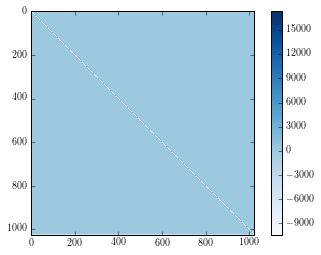

In [4]:
plt.imshow(H_sampled, interpolation="none"); plt.colorbar(); plt.show()

E[0] = -95.5531875434
E[1] = -95.5531875434
E[2] = -86.7633541611
E[3] = -86.7633541611
E[4] = -78.1354749183
E[5] = -78.1354749183


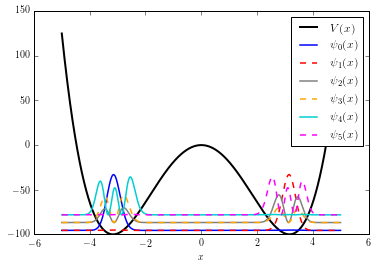

In [5]:
# quick and dirty visualization:

N_plot_min = 0  # quantum number of first eigenfunction to plot
N_plot = 6  # number of eigenfunctions to plot

WF_scale_factor = (np.max(V_sampled) - np.min(V_sampled))/N_plot
plt.plot(x_vals, V_sampled, ls="-", c="k", lw=2, label="$V(x)$")

style_cycler = cycle(["-", "--"])  # line styles for plotting
color_cyler = cycle(["blue", "red", "gray", "orange", "darkturquoise", "magenta"])

for i in range(N_plot_min, N_plot_min+N_plot):
    # physically normalize WF (norm = 1)
    WF_norm = simps(np.abs(psi[:,i])**2, x=x_vals)
    psi[:,i] /= np.sqrt(WF_norm)
    # higher energy --> higher offset in plotting
    WF_plot =  WF_scale_factor*np.abs(psi[:,i])**2 + E[i]  # also try plotting real part of WF!
    plt.plot(x_vals, WF_plot, ls=style_cycler.next(), lw=1.5, color=color_cyler.next(),
             label="$\psi_{}(x)$".format(i))  
    print("E[%s] = %s"%(i, E[i]))

plt.xlabel("$x$")
plt.legend(loc="best")
plt.show()
